# 自定义层

深度学习成功背后的一个因素是神经网络的灵活性：
我们可以用创造性的方式组合不同的层，从而设计出适用于各种任务的架构。
例如，研究人员发明了专门用于处理图像、文本、序列数据和执行动态规划的层。
有时我们会遇到或要自己发明一个现在在深度学习框架中还不存在的层。
在这些情况下，必须构建自定义层。本节将展示如何构建自定义层。

## 不带参数的层

首先，我们(**构造一个没有任何参数的自定义层**)。
回忆一下在 :numref:`sec_model_construction`对块的介绍，
这应该看起来很眼熟。
下面的`CenteredLayer`类要从其输入中减去均值。
要构建它，我们只需继承基础层类并实现前向传播功能。


In [16]:
import torch
import torch.nn.functional as F
from torch import nn
from IPython.display import Image


class CenteredLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X):
        return X - X.mean()

让我们向该层提供一些数据，验证它是否能按预期工作。


In [4]:
layer = CenteredLayer()
layer(torch.FloatTensor([1, 2, 3, 4, 5]))

tensor([-2., -1.,  0.,  1.,  2.])

现在，我们可以[**将层作为组件合并到更复杂的模型中**]。


In [5]:
net = nn.Sequential(nn.Linear(8, 128), CenteredLayer())

作为额外的健全性检查，我们可以在向该网络发送随机数据后，检查均值是否为0。
由于我们处理的是浮点数，因为存储精度的原因，我们仍然可能会看到一个非常小的非零数。


In [6]:
Y = net(torch.rand(4, 8))
Y.mean()

tensor(-1.1642e-08, grad_fn=<MeanBackward0>)

## [**带参数的层**]

以上我们知道了如何定义简单的层，下面我们继续定义具有参数的层，
这些参数可以通过训练进行调整。
我们可以使用内置函数来创建参数，这些函数提供一些基本的管理功能。
比如管理访问、初始化、共享、保存和加载模型参数。
这样做的好处之一是：我们不需要为每个自定义层编写自定义的序列化程序。

现在，让我们实现自定义版本的全连接层。
回想一下，该层需要两个参数，一个用于表示权重，另一个用于表示偏置项。
在此实现中，我们使用修正线性单元作为激活函数。
该层需要输入参数：`in_units`和`units`，分别表示输入数和输出数。


In [7]:
class MyLinear(nn.Module):
    def __init__(self, in_units, units):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_units, units))
        self.bias = nn.Parameter(torch.randn(units,))
        
    def forward(self, X):
        linear = torch.matmul(X, self.weight.data) + self.bias.data
        return F.relu(linear)

接下来，我们实例化`MyLinear`类并访问其模型参数。


In [8]:
linear = MyLinear(5, 3)
linear.weight

Parameter containing:
tensor([[ 0.9330,  0.7393, -0.3739],
        [-0.6883,  0.8206, -0.2679],
        [ 0.6758, -0.7828,  1.7523],
        [-0.3607,  2.4078, -0.9339],
        [-1.4656, -0.6894, -0.8464]], requires_grad=True)

我们可以[**使用自定义层直接执行前向传播计算**]。


In [9]:
linear(torch.rand(2, 5))

tensor([[1.8441, 1.9172, 0.0000],
        [1.0524, 0.5863, 0.2676]])

我们还可以(**使用自定义层构建模型**)，就像使用内置的全连接层一样使用自定义层。


In [15]:
net = nn.Sequential(MyLinear(64, 8), MyLinear(8, 1))
net(torch.rand(2, 64))

tensor([[7.0658],
        [0.0000]])

## 小结

* 我们可以通过基本层类设计自定义层。这允许我们定义灵活的新层，其行为与深度学习框架中的任何现有层不同。
* 在自定义层定义完成后，我们就可以在任意环境和网络架构中调用该自定义层。
* 层可以有局部参数，这些参数可以通过内置函数创建。

## 练习

1. 设计一个接受输入并计算张量降维的层，它返回$y_k = \sum_{i, j} W_{ijk} x_i x_j$。相当于$y_k = \sum_{i, j} A^{(k)} x_i x_j$，$A^{(k)} = [W_{ijk}]_{i,j}$
 
2. 设计一个返回输入数据的傅立叶系数前半部分的层。


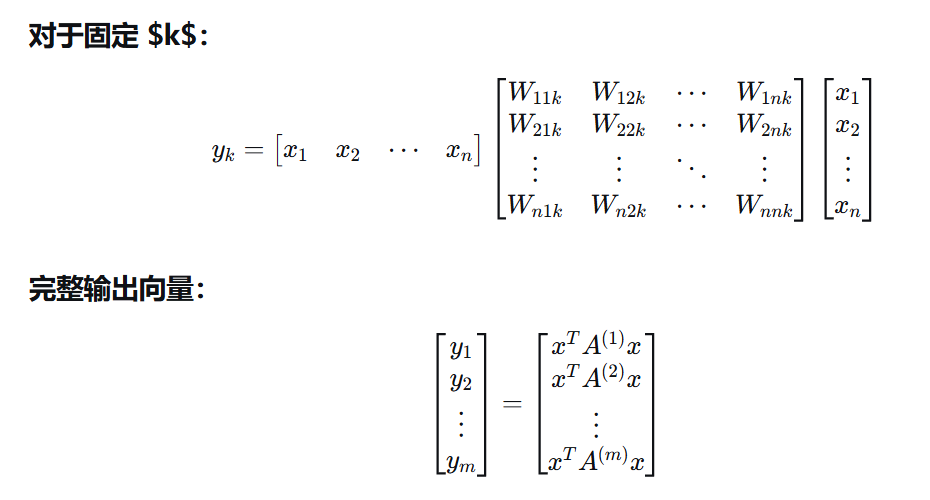

In [19]:
Image(filename="./pic.png", width=500, height=1000)

[Discussions](https://discuss.d2l.ai/t/1835)


In [ ]:
class DimReduction(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(input_dim, input_dim, output_dim))

    def forward(self, x):
        if x.dim() == 1:
            x.unsqueeze(0)
        
        x = torch.sum(torch.matual(torch.matual(x, self.weight), x ) )


        return ..

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BilinearReduction(nn.Module):
    """
    双线性降维层: y_k = sum_{i,j} W_{ijk} x_i x_j
    
    参数:
        input_dim: 输入特征维度 (i, j 的维度)
        output_dim: 输出特征维度 (k 的维度)
        bias: 是否添加偏置项
    """
    def __init__(self, input_dim, output_dim, bias=True):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # 权重张量 W: [input_dim, input_dim, output_dim]
        # W_{ijk} 其中 i,j 是输入索引，k 是输出索引
        self.weight = nn.Parameter(torch.Tensor(input_dim, input_dim, output_dim))
        
        # 可选偏置
        if bias:
            self.bias = nn.Parameter(torch.Tensor(output_dim))
        else:
            self.register_parameter('bias', None)
        
        # 初始化参数
        self.reset_parameters()
    
    def reset_parameters(self):
        # Xavier 初始化
        nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)
    
    def forward(self, x):
        """
        前向传播
        
        参数:
            x: 输入张量 [batch_size, input_dim] 或 [input_dim]
            
        返回:
            y: 输出张量 [batch_size, output_dim] 或 [output_dim]
        """
        # 确保输入有批次维度
        if x.dim() == 1:
            x = x.unsqueeze(0)  # [input_dim] -> [1, input_dim]
            squeeze_output = True
        else:
            squeeze_output = False
        
        batch_size = x.size(0)
        
        # 使用 einsum 清晰表达计算
        # 公式: y_{bk} = sum_{i,j} W_{ijk} x_{bi} x_{bj}
        y = torch.einsum('bi,bj,ijk->bk', x, x, self.weight)
        
        # 添加偏置
        if self.bias is not None:
            y = y + self.bias.unsqueeze(0)
        
        # 如果输入是单样本，移除批次维度
        if squeeze_output:
            y = y.squeeze(0)
        
        return y
    
    def extra_repr(self):
        return f"input_dim={self.input_dim}, output_dim={self.output_dim}, bias={self.bias is not None}"

In [ ]:
def forward_matrix_multiplication(self, x):
    batch_size = x.shape[0]
    y = torch.zeros(batch_size, self.k, device=x.device)
    
    for k in range(self.k):
        W_k = self.weight[:, :, k]  # [i, j] 矩阵
        # 计算: y[:,k] = diag(x @ W_k @ x.T)
        # 但更高效的是: (x @ W_k) * x 然后求和
        y[:, k] = torch.sum(x @ W_k * x, dim=1)
    
    return y

In [ ]:
# 计算: y[:,k] = diag(x @ W_k @ x.T)
# 分解步骤:
# 1. x @ W_k: [batch_size, i] @ [i, i] = [batch_size, i]
# 2. (x @ W_k) @ x.T: [batch_size, i] @ [i, batch_size] = [batch_size, batch_size]
# 3. diag(): 取对角线 -> [batch_size]


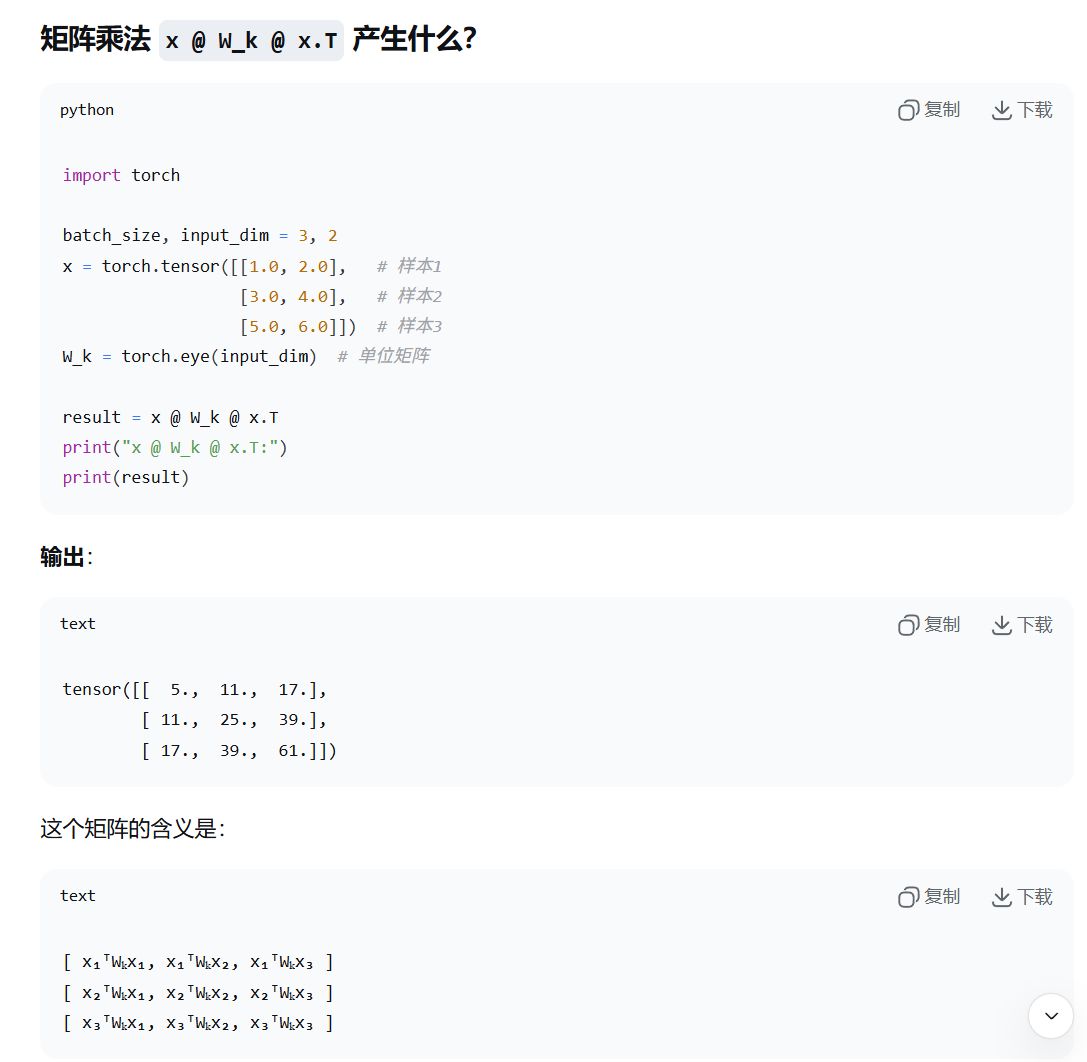

In [20]:
Image(filename="./pic2.png", width=500, height=1000)

In [ ]:
# 计算: (x @ W_k) * x 然后求和
# 分解步骤:
# 1. x @ W_k: [batch_size, i] @ [i, i] = [batch_size, i]
# 2. (x @ W_k) * x: [batch_size, i] * [batch_size, i] = [batch_size, i] (逐元素相乘)
# 3. sum(dim=1): [batch_size, i] -> [batch_size]